# Differential gene expression analysis

This notebook will focus on the first objective, i.e. evaluate the feasibility of conducting the analysis exclusively in Python. 

tl;dr: As I was able to regenerate results and plots very similar to the original paper, it is fair to say that Python is capable of gene expression analysis. 

## Setup

In [1]:
import os
import numpy as np
import pandas as pd
import pickle as pkl
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats

In [2]:
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

## Import data

In [3]:
file_path = "../datasets/E-MTAB-6863-raw-counts.tsv"
df = pd.read_csv(file_path, sep="\t", comment='#')
df.head()

,Gene ID,Gene Name,ERR2618748,ERR2618749,ERR2618751,ERR2618752,ERR2618753,ERR2618754,ERR2618755,ERR2618756,ERR2618757,ERR2618758,ERR2618759,ERR2618760,ERR2618761,ERR2618762,ERR2618763,ERR2618764,ERR2618765,ERR2618766,ERR2618781,ERR2618782,ERR2618784,ERR2618785,ERR2618786,ERR2618787,ERR2618788,ERR2618789,ERR2618790,ERR2618791,ERR2618802,ERR2618803,ERR2618804,ERR2618805,ERR2618806,ERR2618807,ERR2618808,ERR2618809,ERR2618810,ERR2618811,ERR2618814,ERR2618769,ERR2618773,ERR2618783,ERR2618770,ERR2618774,ERR2618795,ERR2618813,ERR2618776,ERR2618779,ERR2618812,ERR2618777,ERR2618796,ERR2618797,ERR2618772,ERR2618794,ERR2618775,ERR2618792,ERR2618768,ERR2618793,ERR2618767,ERR2618798,ERR2618771,ERR2618815,ERR2618778,ERR2618800,ERR2618780,ERR2618799,ERR2618801,ERR2618816,ERR2618750
0,ENSG00000000003,TSPAN6,2230,1191,1592,1936,1506,1717,1489,1882,1109,364,1740,1311,921,1376,1133,1822,1490,1334,1241,1221,1901,797,858,1064,390,1517,1067,421,489,354,1584,1296,2202,1444,2015,1262,1262,1915,705,1084,1329,551,1795,1560,365,1123,537,1928,2536,1654,529,844,679,1223,1675,1007,1154,1684,2284,1501,913,722,1346,2215,1593,735,1332,657,829
1,ENSG00000000005,TNMD,12,6,5,2,3,1,1,21,19,5,13,2,0,1,6,4,1,10,1,3,2,16,4,0,2,0,1,1,1,3,8,2,8,3,12,5,4,3,2,4,0,0,5,6,5,5,5,11,35,8,2,1,0,3,2,0,2,4,7,0,4,0,5,2,0,0,1,0,2
2,ENSG00000000419,DPM1,404,339,396,326,343,335,292,491,275,381,332,284,273,391,184,326,345,257,419,263,430,233,193,187,74,291,267,56,101,87,380,262,486,393,431,287,192,325,102,124,263,96,372,272,77,290,141,323,439,392,118,195,108,329,244,141,253,342,502,354,173,107,420,471,301,126,302,141,165
3,ENSG00000000457,SCYL3,670,422,375,347,417,403,318,528,338,230,347,285,434,372,214,407,366,268,516,386,604,400,303,222,127,180,336,37,178,175,598,379,623,272,677,324,220,351,102,214,427,124,440,499,74,388,389,269,478,479,133,213,243,465,416,262,381,474,530,208,194,186,437,555,285,146,444,244,222
4,ENSG00000000460,C1orf112,111,116,97,73,64,108,38,153,86,77,85,53,82,75,33,123,56,49,92,94,242,115,84,61,22,50,122,19,56,88,239,122,366,134,199,99,37,139,29,76,73,47,159,100,30,109,79,57,135,110,28,58,27,158,102,83,101,89,96,43,51,46,111,121,65,13,94,61,69


In [4]:
# Examine all patients
file_path = "../datasets/E-MTAB-6863-experiment-design.tsv"
edf = pd.read_csv(file_path, sep="\t", comment='#')
# edf = edf[edf["Sample Characteristic[disease]"] == "non-alcoholic fatty liver disease"]
print(edf.shape)
edf.head()

(69, 46)


,Run,Sample Characteristic[age],Sample Characteristic Ontology Term[age],Sample Characteristic[alcohol consumption],Sample Characteristic Ontology Term[alcohol consumption],Sample Characteristic[alcohol consumption measurement],Sample Characteristic Ontology Term[alcohol consumption measurement],Sample Characteristic[bmi code],Sample Characteristic Ontology Term[bmi code],Sample Characteristic[body mass index],Sample Characteristic Ontology Term[body mass index],Sample Characteristic[cigarette packs per year],Sample Characteristic Ontology Term[cigarette packs per year],Sample Characteristic[clinical information],Sample Characteristic Ontology Term[clinical information],Sample Characteristic[diabetes],Sample Characteristic Ontology Term[diabetes],Sample Characteristic[disease],Sample Characteristic Ontology Term[disease],Sample Characteristic[disease staging],Sample Characteristic Ontology Term[disease staging],Sample Characteristic[elf score],Sample Characteristic Ontology Term[elf score],Sample Characteristic[ethnic group],Sample Characteristic Ontology Term[ethnic group],Sample Characteristic[fibrosis stage],Sample Characteristic Ontology Term[fibrosis stage],Sample Characteristic[infect],Sample Characteristic Ontology Term[infect],Sample Characteristic[organism],Sample Characteristic Ontology Term[organism],Sample Characteristic[organism part],Sample Characteristic Ontology Term[organism part],Sample Characteristic[sex],Sample Characteristic Ontology Term[sex],Sample Characteristic[smoker],Sample Characteristic Ontology Term[smoker],Factor Value[clinical information],Factor Value Ontology Term[clinical information],Factor Value[disease],Factor Value Ontology Term[disease],Factor Value[disease staging],Factor Value Ontology Term[disease staging],Factor Value[infect],Factor Value Ontology Term[infect],Analysed
0,ERR2618748,49 year,NaN,0 grams per week,NaN,0,NaN,0,NaN,24.1,NaN,0 cigarette packs per year,NaN,no steatosis,NaN,non-diabetic,http://www.ebi.ac.uk/efo/EFO_0001461,liver disease,http://www.ebi.ac.uk/efo/EFO_0001421,early,NaN,enhanced liver fibrosis score 9.09,NaN,Caucasian,http://purl.obolibrary.org/obo/HANCESTRO_0005,METAVIR fibrosis score 2,NaN,Hepacivirus C,http://purl.obolibrary.org/obo/NCBITaxon_11103,Homo sapiens,http://purl.obolibrary.org/obo/NCBITaxon_9606,liver,http://purl.obolibrary.org/obo/UBERON_0002107,male,http://purl.obolibrary.org/obo/PATO_0000384,non smoker,NaN,no steatosis,NaN,liver disease,http://www.ebi.ac.uk/efo/EFO_0001421,early,NaN,Hepacivirus C,http://purl.obolibrary.org/obo/NCBITaxon_11103,No
1,ERR2618749,53 year,NaN,0 grams per week,NaN,0,NaN,1,NaN,29.74,NaN,not available,NaN,steatosis,NaN,not available,NaN,liver disease,http://www.ebi.ac.uk/efo/EFO_0001421,advanced,NaN,not available,NaN,not available,NaN,METAVIR fibrosis score 4,NaN,Hepacivirus C,http://purl.obolibrary.org/obo/NCBITaxon_11103,Homo sapiens,http://purl.obolibrary.org/obo/NCBITaxon_9606,liver,http://purl.obolibrary.org/obo/UBERON_0002107,male,http://purl.obolibrary.org/obo/PATO_0000384,not available,NaN,steatosis,NaN,liver disease,http://www.ebi.ac.uk/efo/EFO_0001421,advanced,NaN,Hepacivirus C,http://purl.obolibrary.org/obo/NCBITaxon_11103,No
2,ERR2618750,50 year,NaN,not available,NaN,not available,NaN,0,NaN,not available,NaN,not available,NaN,no steatosis,NaN,not available,NaN,liver disease,http://www.ebi.ac.uk/efo/EFO_0001421,advanced,NaN,not available,NaN,not available,NaN,METAVIR fibrosis score 3,NaN,Hepacivirus C,http://purl.obolibrary.org/obo/NCBITaxon_11103,Homo sapiens,http://purl.obolibrary.org/obo/NCBITaxon_9606,liver,http://purl.obolibrary.org/obo/UBERON_0002107,female,http://purl.obolibrary.org/obo/PATO_0000383,not available,NaN,no steatosis,NaN,liver disease,http://www.ebi.ac.uk/efo/EFO_0001421,advanced,NaN,Hepacivirus C,http://purl.obolibrary.org/obo/NCBITaxon_11103,No
3,ERR2618751,64 year,NaN,0 grams per week,NaN,0,NaN,1,NaN,32.3,NaN,0 cigarette packs per year,NaN,no steatosis,NaN,type II diabetes mellitus,http:/

In [5]:
# Filter counts df by only non-alcoholic fatty liver disease patients
counts_df = df[["Gene ID"] + edf["Run"].tolist()].set_index("Gene ID")
print(counts_df.shape)
counts_df.head()

(58735, 69)


,ERR2618748,ERR2618749,ERR2618750,ERR2618751,ERR2618752,ERR2618753,ERR2618754,ERR2618755,ERR2618756,ERR2618757,ERR2618758,ERR2618759,ERR2618760,ERR2618761,ERR2618762,ERR2618763,ERR2618764,ERR2618765,ERR2618766,ERR2618767,ERR2618768,ERR2618769,ERR2618770,ERR2618771,ERR2618772,ERR2618773,ERR2618774,ERR2618775,ERR2618776,ERR2618777,ERR2618778,ERR2618779,ERR2618780,ERR2618781,ERR2618782,ERR2618783,ERR2618784,ERR2618785,ERR2618786,ERR2618787,ERR2618788,ERR2618789,ERR2618790,ERR2618791,ERR2618792,ERR2618793,ERR2618794,ERR2618795,ERR2618796,ERR2618797,ERR2618798,ERR2618799,ERR2618800,ERR2618801,ERR2618802,ERR2618803,ERR2618804,ERR2618805,ERR2618806,ERR2618807,ERR2618808,ERR2618809,ERR2618810,ERR2618811,ERR2618812,ERR2618813,ERR2618814,ERR2618815,ERR2618816
Gene ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,2230,1191,829,1592,1936,1506,1717,1489,1882,1109,364,1740,1311,921,1376,1133,1822,1490,1334,2284,1154,1084,1795,913,679,1329,1560,1675,537,1654,1346,1928,1593,1241,1221,551,1901,797,858,1064,390,1517,1067,421,1007,1684,1223,365,529,844,1501,735,2215,1332,489,354,1584,1296,2202,1444,2015,1262,1262,1915,2536,1123,705,722,657
ENSG00000000005,12,6,2,5,2,3,1,1,21,19,5,13,2,0,1,6,4,1,10,7,2,4,5,4,0,0,6,2,5,8,5,11,0,1,3,0,2,16,4,0,2,0,1,1,0,4,3,5,2,1,0,0,2,1,1,3,8,2,8,3,12,5,4,3,35,5,2,0,0
ENSG00000000419,404,339,165,396,326,343,335,292,491,275,381,332,284,273,391,184,326,345,257,502,253,124,372,173,108,263,272,244,141,392,420,323,301,419,263,96,430,233,193,187,74,291,267,56,141,342,329,77,118,195,354,126,471,302,101,87,380,262,486,393,431,287,192,325,439,290,102,107,141
ENSG00000000457,670,422,222,375,347,417,403,318,528,338,230,347,285,434,372,214,407,366,268,530,381,214,440,194,243,427,499,416,389,479,437,269,285,516,386,124,604,400,303,222,127,180,336,37,262,474,465,74,133,213,208,146,555,444,178,175,598,379,623,272,677,324,220,351,478,388,102,186,244
ENSG00000000460,111,116,69,97,73,64,108,38,153,86,77,85,53,82,75,33,123,56,49,96,101,76,159,51,27,73,100,102,79,110,111,57,65,92,94,47,242,115,84,61,22,50,122,19,83,89,158,30,28,58,43,13,121,94,56,88,239,122,366,134,199,99,37,139,135,109,29,46,61


## EDA

In [6]:
# Check the distributions of read counts for each sample
summary_df = counts_df.describe().round()
summary_df.loc["sum"] = summary_df.loc["count"] * summary_df.loc["mean"]
summary_df

,ERR2618748,ERR2618749,ERR2618750,ERR2618751,ERR2618752,ERR2618753,ERR2618754,ERR2618755,ERR2618756,ERR2618757,ERR2618758,ERR2618759,ERR2618760,ERR2618761,ERR2618762,ERR2618763,ERR2618764,ERR2618765,ERR2618766,ERR2618767,ERR2618768,ERR2618769,ERR2618770,ERR2618771,ERR2618772,ERR2618773,ERR2618774,ERR2618775,ERR2618776,ERR2618777,ERR2618778,ERR2618779,ERR2618780,ERR2618781,ERR2618782,ERR2618783,ERR2618784,ERR2618785,ERR2618786,ERR2618787,ERR2618788,ERR2618789,ERR2618790,ERR2618791,ERR2618792,ERR2618793,ERR2618794,ERR2618795,ERR2618796,ERR2618797,ERR2618798,ERR2618799,ERR2618800,ERR2618801,ERR2618802,ERR2618803,ERR2618804,ERR2618805,ERR2618806,ERR2618807,ERR2618808,ERR2618809,ERR2618810,ERR2618811,ERR2618812,ERR2618813,ERR2618814,ERR2618815,ERR2618816
count,58735.0,58735.0,58735.0,58735.0,58735.0,58735.0,58735.0,58735.0,58735.0,58735.0,58735.0,58735.0,58735.0,58735.0,58735.0,58735.0,58735.0,58735.0,58735.0,58735.0,58735.0,58735.0,58735.0,58735.0,58735.0,58735.0,58735.0,58735.0,58735.0,58735.0,58735.0,58735.0,58735.0,58735.0,58735.0,58735.0,58735.0,58735.0,58735.0,58735.0,58735.0,58735.0,58735.0,58735.0,58735.0,58735.0,58735.0,58735.0,58735.0,58735.0,58735.0,58735.0,58735.0,58735.0,58735.0,58735.0,58735.0,58735.0,58735.0,58735.0,58735.0,58735.0,58735.0,58735.0,58735.0,58735.0,58735.0,58735.0,58735.0
mean,399.0,292.0,172.0,301.0,382.0,349.0,329.0,283.0,361.0,261.0,239.0,286.0,319.0,228.0,239.0,269.0,320.0,306.0,240.0,419.0,255.0,178.0,306.0,159.0,245.0,374.0,297.0,350.0,166.0,365.0,339.0,396.0,261.0,374.0,271.0,148.0,377.0,274.0,196.0,232.0,123.0,235.0,222.0,77.0,208.0,342.0,281.0,95.0,116.0,170.0,269.0,280.0,403.0,320.0,116.0,105.0,351.0,270.0,430.0,232.0,421.0,230.0,240.0,261.0,377.0,213.0,139.0,238.0,160.0
std,11900.0,5742.0,5304.0,10076.0,11710.0,9509.0,8047.0,6653.0,12224.0,8128.0,8904.0,8535.0,7435.0,4961.0,5360.0,7383.0,9618.0,8565.0,5852.0,13010.0,8455.0,5163.0,10107.0,5724.0,5405.0,7962.0,6741.0,10167.0,3169.0,11955.0,7389.0,11799.0,7939.0,8703.0,8523.0,3097.0,14866.0,8355.0,4705.0,5248.0,5446.0,7077.0,6824.0,3268.0,5599.0,11388.0,5220.0,3989.0,3315.0,5023.0,8850.0,7624.0,12321.0,7940.0,3026.0,2184.0,9957.0,7180.0,13568.0,7878.0,11857.0,6322.0,6950.0,10165.0,12306.0,5990.0,3313.0,5150.0,3583.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,2.0,1.0,0.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,0.0,0.0,2.0,2.0,1.0,1.0,2.0,1.0,0.0,1.0,2.0,2.0,0.0,2.0,2.0,2.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,2.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0,2.0,1.0,2.0,2.0,2.0,1.0,3.0,1.0,0.0,1.0,2.0,2.0,0.0,0.0,1.0
75%,44.0,45.0,19.0,27.0,28.0,33.0,28.0,20.0,32.0,29.0,32.0,29.0,27.0,42.0,26.0,15.0,33.0,28.0,19.0,42.0,28.0,22.0,28.0,14.0,19.0,38.0,35.0,29.0,30.0,42.0,34.0,18.0,25.0,34.0,34.0,10.0,44.0,34.0,32.0,17.0,10.0,14.0,28.0,3.0,19.0,34.0,44.0,5.0,8.0,16.0,15.0,12.0,34.0,43.0,18.0,17.0,41.0,35.0,44.0,22.0,55.0,26.0,14.0,20.0,35.0,31.0,8.0,14.0,20.0
max,2668770.0,1170743.0,1157565.0,2260307.0,2549560.0,2069515.0,1695585.0,1318436.0,2779845.0,1816901.0,2067890.0,1926902.0,1492601.0,1072733.0,1155746.0,1546056.0,2089781.0,1853154.0,1171209.0,2907827.0,1921439.0,1111508.0,2285732.0,1232483.0,933476.0,1501847.0,1381650.0,2219057.0,502520.0,2717822.0,1513736.0,2299931.0,1771021.0,1610416.0,1901567.0,469480.0,3454153.0,1834040.0,1013619.0,1017661.0,1079752.0,1542625.0,1538090.0,602504.0,1185935.0,2570952.0,1015155.0,871185.0,676149.0,928045.0,1966012.0,1479736.0,2751524.0,1713011.0,664434.0,407997.0,2208501.0,1601834.0,30

In [7]:
# Check read count per sample by millions
summary_df.loc["sum"] / 1e6

ERR2618748    23.435265
ERR2618749    17.150620
ERR2618750    10.102420
ERR2618751    17.679235
ERR2618752    22.436770
ERR2618753    20.498515
ERR2618754    19.323815
ERR2618755    16.622005
ERR2618756    21.203335
ERR2618757    15.329835
ERR2618758    14.037665
ERR2618759    16.798210
ERR2618760    18.736465
ERR2618761    13.391580
ERR2618762    14.037665
ERR2618763    15.799715
ERR2618764    18.795200
ERR2618765    17.972910
ERR2618766    14.096400
ERR2618767    24.609965
ERR2618768    14.977425
ERR2618769    10.454830
ERR2618770    17.972910
ERR2618771     9.338865
ERR2618772    14.390075
ERR2618773    21.966890
ERR2618774    17.444295
ERR2618775    20.557250
ERR2618776     9.750010
ERR2618777    21.438275
ERR2618778    19.911165
ERR2618779    23.259060
ERR2618780    15.329835
ERR2618781    21.966890
ERR2618782    15.917185
ERR2618783     8.692780
ERR2618784    22.143095
ERR2618785    16.093390
ERR2618786    11.512060
ERR2618787    13.626520
ERR2618788     7.224405
ERR2618789    13

In [8]:
# Filter the data with a threshold of ≥10 counts per million (CPM) in at least 20 samples (29%)
# This is based on the paper
threshold = summary_df.loc["sum"]/1e6 * 10
counts_df1 = counts_df
filtered_df = counts_df[(counts_df1 > threshold).sum(axis=1) >= 20]
print(filtered_df.shape)
filtered_df.head()

(9813, 69)


,ERR2618748,ERR2618749,ERR2618750,ERR2618751,ERR2618752,ERR2618753,ERR2618754,ERR2618755,ERR2618756,ERR2618757,ERR2618758,ERR2618759,ERR2618760,ERR2618761,ERR2618762,ERR2618763,ERR2618764,ERR2618765,ERR2618766,ERR2618767,ERR2618768,ERR2618769,ERR2618770,ERR2618771,ERR2618772,ERR2618773,ERR2618774,ERR2618775,ERR2618776,ERR2618777,ERR2618778,ERR2618779,ERR2618780,ERR2618781,ERR2618782,ERR2618783,ERR2618784,ERR2618785,ERR2618786,ERR2618787,ERR2618788,ERR2618789,ERR2618790,ERR2618791,ERR2618792,ERR2618793,ERR2618794,ERR2618795,ERR2618796,ERR2618797,ERR2618798,ERR2618799,ERR2618800,ERR2618801,ERR2618802,ERR2618803,ERR2618804,ERR2618805,ERR2618806,ERR2618807,ERR2618808,ERR2618809,ERR2618810,ERR2618811,ERR2618812,ERR2618813,ERR2618814,ERR2618815,ERR2618816
Gene ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,2230,1191,829,1592,1936,1506,1717,1489,1882,1109,364,1740,1311,921,1376,1133,1822,1490,1334,2284,1154,1084,1795,913,679,1329,1560,1675,537,1654,1346,1928,1593,1241,1221,551,1901,797,858,1064,390,1517,1067,421,1007,1684,1223,365,529,844,1501,735,2215,1332,489,354,1584,1296,2202,1444,2015,1262,1262,1915,2536,1123,705,722,657
ENSG00000000419,404,339,165,396,326,343,335,292,491,275,381,332,284,273,391,184,326,345,257,502,253,124,372,173,108,263,272,244,141,392,420,323,301,419,263,96,430,233,193,187,74,291,267,56,141,342,329,77,118,195,354,126,471,302,101,87,380,262,486,393,431,287,192,325,439,290,102,107,141
ENSG00000000457,670,422,222,375,347,417,403,318,528,338,230,347,285,434,372,214,407,366,268,530,381,214,440,194,243,427,499,416,389,479,437,269,285,516,386,124,604,400,303,222,127,180,336,37,262,474,465,74,133,213,208,146,555,444,178,175,598,379,623,272,677,324,220,351,478,388,102,186,244
ENSG00000000938,157,279,109,77,258,239,141,118,122,181,76,196,290,235,107,123,155,116,133,213,112,58,110,58,183,312,221,89,115,263,139,203,192,105,163,107,128,112,159,150,55,115,157,22,115,168,229,58,31,90,99,77,201,220,41,45,155,139,150,71,127,72,71,72,138,125,45,213,73
ENSG00000000971,62001,27855,23001,52824,34486,37544,31418,26071,57083,39032,7673,44633,26587,26237,40226,26343,35506,41400,18290,58411,32621,23859,62585,23966,13551,29158,49888,44749,15711,58148,40032,37498,25443,51637,45349,9149,60166,41505,23421,16974,9346,28769,38209,7479,20922,51904,43289,4940,10100,22575,34126,25488,45494,40933,17604,13910,59106,36663,90130,46373,69927,35273,29166,61554,64106,26802,7260,8808,20042


The paper identified a total of 9,624 genes passing this criterion, while I detected 9,813 genes. Not sure where the small discrepancy are coming from. 

### PCA analysis

In [9]:
pca = PCA(n_components=3)
normalized_df=pd.DataFrame(StandardScaler().fit_transform(filtered_df.T))

pca.fit(normalized_df)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.56148214 0.15327963 0.06650197]
[616.58565564 322.15706524 212.1986926 ]


In [10]:
projected = pca.fit_transform(normalized_df)
print(normalized_df.shape)
print(projected.shape)

(69, 9813)
(69, 3)


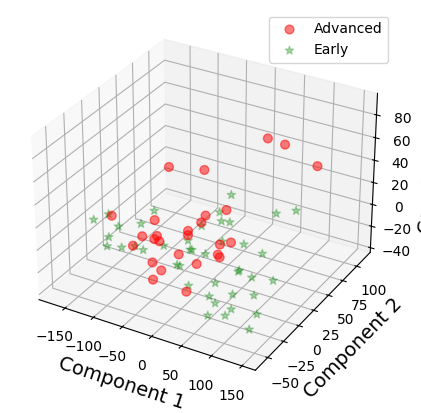

In [11]:
y=edf["Sample Characteristic[disease staging]"]

ex_variance=np.var(projected,axis=0)
ex_variance_ratio = ex_variance/np.sum(ex_variance)
ex_variance_ratio


Xax = projected[:,0]
Yax = projected[:,1]
Zax = projected[:,2]

cdict = {'early':'green','advanced':'red'}
label = {'early':'Early','advanced':'Advanced'}
marker = {'early':'*','advanced':'o'}
alpha = {'early':.3, 'advanced':.5}

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(projection='3d')

fig.patch.set_facecolor('white')
for l in np.unique(y):
 ix=np.where(y==l)
 ax.scatter(Xax[ix], Yax[ix], Zax[ix], c=cdict[l], s=40,
           label=label[l], marker=marker[l], alpha=alpha[l])
# for loop ends
ax.set_xlabel("Component 1", fontsize=14)
ax.set_ylabel("Component 2", fontsize=14)
ax.set_zlabel("Component 3", fontsize=14)

ax.legend()
plt.show()

The PCA separateion is not as obvious as in the paper. A couple of things to try:
* Other pca packages
* An interactive widget to look at the 3d plot from different angles

## Differential expression analysis

In [12]:
# Transform the data to be sample as rows and genes as columns
filtered_df = filtered_df.T
print(filtered_df.shape)
filtered_df.head()

(69, 9813)


Gene ID,ENSG00000000003,ENSG00000000419,ENSG00000000457,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,ENSG00000001461,ENSG00000001497,ENSG00000001561,ENSG00000001617,ENSG00000001626,ENSG00000001629,ENSG00000001630,ENSG00000001631,ENSG00000002016,ENSG00000002330,ENSG00000002549,ENSG00000002586,ENSG00000002822,ENSG00000002834,ENSG00000002919,ENSG00000002933,ENSG00000003056,ENSG00000003147,ENSG00000003393,ENSG00000003400,ENSG00000003402,ENSG00000003436,ENSG00000003509,ENSG00000003756,ENSG00000003989,ENSG00000004059,ENSG00000004139,ENSG00000004142,ENSG00000004399,ENSG00000004455,ENSG00000004468,ENSG00000004478,ENSG00000004487,ENSG00000004534,ENSG00000004700,ENSG00000004766,ENSG00000004779,ENSG00000004799,ENSG00000004864,ENSG00000004866,ENSG00000004897,ENSG00000004961,ENSG00000004975,ENSG00000005007,ENSG00000005020,ENSG00000005022,ENSG00000005075,ENSG00000005100,ENSG00000005108,ENSG00000005156,ENSG00000005175,ENSG00000005187,ENSG00000005194,ENSG00000005206,ENSG00000005238,ENSG00000005243,ENSG00000005302,ENSG00000005339,ENSG00000005379,ENSG00000005421,ENSG00000005436,ENSG00000005469,ENSG00000005471,ENSG00000005483,ENSG00000005486,ENSG00000005700,ENSG00000005801,ENSG00000005810,ENSG00000005812,ENSG00000005844,ENSG00000005882,ENSG00000005889,ENSG00000005893,ENSG00000006007,ENSG00000006015,ENSG00000006042,ENSG00000006062,ENSG00000006125,ENSG00000006194,ENSG00000006210,ENSG00000006282,ENSG00000006432,ENSG00000006451,ENSG00000006453,ENSG00000006459,ENSG00000006530,ENSG00000006576,ENSG00000006607,ENSG00000006652,ENSG00000006695,ENSG00000006712,ENSG00000006715,ENSG00000006744,ENSG00000006756,ENSG00000006757,ENSG00000006831,ENSG00000007001,ENSG00000007047,ENSG00000007080,ENSG00000007168,ENSG00000007202,ENSG00000007237,ENSG00000007255,ENSG00000007341,ENSG00000007392,ENSG00000007516,ENSG00000007520,ENSG00000007541,ENSG00000007545,ENSG00000007923,ENSG00000007933,ENSG00000008018,ENSG00000008083,ENSG00000008086,ENSG00000008130,ENSG00000008256,ENSG00000008282,ENSG00000008283,ENSG00000008294,ENSG00000008311,ENSG00000008323,ENSG00000008382,ENSG00000008394,ENSG00000008405,ENSG00000008441,ENSG00000008513,ENSG00000008517,ENSG00000008710,ENSG00000008838,ENSG00000008869,ENSG00000008952,ENSG00000008988,ENSG00000009307,ENSG00000009335,ENSG00000009413,ENSG00000009694,ENSG00000009724,ENSG00000009765,ENSG00000009780,ENSG00000009790,ENSG00000009830,ENSG00000009844,ENSG00000009950,ENSG00000009954,ENSG00000010017,ENSG00000010030,ENSG00000010072,ENSG00000010165,ENSG00000010244,ENSG00000010256,ENSG00000010270,ENSG00000010278,ENSG00000010292,ENSG00000010295,ENSG00000010322,ENSG00000010327,ENSG00000010379,ENSG00000010404,ENSG00000010610,ENSG00000010704,ENSG00000010803,ENSG00000010810,ENSG00000010818,ENSG00000011007,ENSG00000011009,ENSG00000011021,ENSG00000011028,ENSG00000011105,ENSG00000011114,ENSG00000011132,ENSG00000011198,ENSG00000011243,ENSG00000011258,ENSG00000011260,ENSG00000011275,ENSG00000011295,ENSG00000011304,ENSG00000011347,ENSG00000011376,ENSG00000011405,ENSG00000011451,ENSG00000011454,ENSG00000011465,ENSG00000011485,ENSG00000011523,ENSG00000011566,ENSG00000011600,ENSG00000012048,ENSG00000012061,ENSG00000012174,ENSG00000012232,ENSG00000012504,ENSG00000012660,ENSG00000012817,ENSG00000012822,ENSG00000012963,ENSG00000012983,ENSG00000013016,ENSG00000013275,ENSG00000013288,ENSG00000013306,ENSG00000013364,ENSG00000013374,ENSG00000013375,ENSG00000013441,ENSG00000013503,ENSG00000013523,ENSG00000013561,ENSG00000013583,ENSG00000013810,ENSG00000014123,ENSG00000014164,ENSG00000014216,ENSG00000014641,ENSG00000014824,ENSG00000014919,ENSG00000015133,ENSG00000015153,ENSG00000015171,ENSG00000015475,ENSG00000015479,ENSG00000015520,ENSG00000015532,ENSG00000015676,ENSG00000016391,ENSG00000016864,ENSG00000017260,ENSG00000017427,ENSG00000017797,ENSG00000018189,ENSG00000018408,ENSG00000018510,ENSG00000018610,ENSG00000018699,ENSG00000019144,ENSG00000019169,ENSG00000019485,ENSG00000019549,ENSG00000019582,ENSG00000019991,ENSG00000019995,ENSG0000

In [13]:
# Prep the metadata to have the groups to run differential expression on
metadata = edf[["Run","Sample Characteristic[disease]", "Sample Characteristic[disease staging]"]]
metadata = metadata.rename(columns={"Sample Characteristic[disease]": "condition", 
                         "Sample Characteristic[disease staging]": "stage"})
metadata = metadata.set_index("Run")
print(metadata.shape)
metadata.head()

(69, 2)


,condition,stage
Run,,
ERR2618748,liver disease,early
ERR2618749,liver disease,advanced
ERR2618750,liver disease,advanced
ERR2618751,liver disease,advanced
ERR2618752,liver disease,early


In [14]:
dds = DeseqDataSet(
    counts=filtered_df,
    metadata=metadata,
    design_factors="stage",
)

In [15]:
dds.deseq2()

Fitting size factors...
... done in 0.06 seconds.

Fitting dispersions...
... done in 12.18 seconds.

Fitting dispersion trend curve...
... done in 0.52 seconds.

Fitting MAP dispersions...
... done in 15.34 seconds.

Fitting LFCs...
... done in 4.09 seconds.

Calculating cook's distance...
... done in 0.09 seconds.

Replacing 83 outlier genes.

Fitting dispersions...
... done in 0.13 seconds.

Fitting MAP dispersions...
... done in 0.16 seconds.

Fitting LFCs...
... done in 0.09 seconds.



In [16]:
print(dds)

AnnData object with n_obs × n_vars = 69 × 9813
    obs: 'condition', 'stage'
    uns: 'trend_coeffs', 'disp_function_type', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors', '_mu_LFC', '_hat_diagonals', 'replaceable'
    varm: '_normed_means', 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced', 'refitted'
    layers: 'normed_counts', '_mu_hat', 'cooks', 'replace_cooks'


In [17]:
dds

AnnData object with n_obs × n_vars = 69 × 9813
    obs: 'condition', 'stage'
    uns: 'trend_coeffs', 'disp_function_type', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors', '_mu_LFC', '_hat_diagonals', 'replaceable'
    varm: '_normed_means', 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced', 'refitted'
    layers: 'normed_counts', '_mu_hat', 'cooks', 'replace_cooks'

In [18]:
stat_res = DeseqStats(dds, independent_filter=False)

In [21]:
# stat_res.summary()
stat_res.results_df[:10]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Gene ID,,,,,,
ENSG00000000003,1187.235403,0.092305,0.097067,0.950937,3.416363e-01,0.492866
ENSG00000000419,249.662645,-0.089383,0.088100,-1.014559,3.103163e-01,0.461524
ENSG00000000457,307.149513,-0.049710,0.070192,-0.708205,4.788180e-01,0.620446
ENSG00000000938,126.322769,-0.138835,0.121916,-1.138773,2.547980e-01,0.404781
ENSG00000000971,30979.713322,-0.006717,0.124654,-0.053888,9.570245e-01,0.974270
ENSG00000001036,491.230702,0.003691,0.077266,0.047772,9.618982e-01,0.977409
ENSG00000001084,2076.178491,0.251443,0.087519,2.873000,4.065945e-03,0.023131
ENSG00000001167,267.259890,-0.081051,0.074192,-1.092452,2.746345e-01,0.424809
ENSG00000001461,249.192239,-0.298977,0.059114,-5.057645,4.244658e-07,0.000028


In [22]:
results_df = stat_res.results_df.sort_values(by=["padj"])
results_df.head(10)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Gene ID,,,,,,
ENSG00000038427,330.953471,-1.431967,0.158153,-9.054302,1.374435e-19,1.348733e-15
ENSG00000122870,223.214305,-1.555669,0.197368,-7.882062,3.220220e-15,1.580001e-11
ENSG00000131711,185.533272,-1.384358,0.182942,-7.567209,3.813295e-14,1.055388e-10
ENSG00000146038,161.394527,-1.757316,0.232710,-7.551522,4.302001e-14,1.055388e-10
ENSG00000196569,700.227039,-1.287160,0.174549,-7.374198,1.653373e-13,3.244909e-10
ENSG00000001626,248.437738,-1.999495,0.273523,-7.310148,2.668484e-13,3.333714e-10
ENSG00000172009,512.371167,0.874585,0.119680,7.307687,2.717794e-13,3.333714e-10
ENSG00000064651,398.261501,-1.107762,0.151089,-7.331833,2.270256e-13,3.333714e-10
ENSG00000184384,168.272599,-0.787353,0.108908,-7.229552,4.845901e-13,5.283647e-10


### Volcano plot

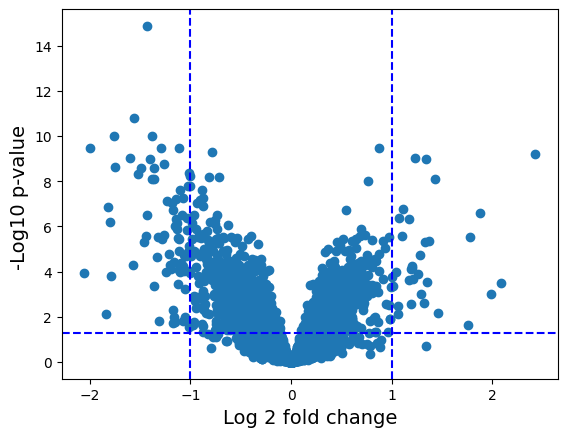

In [23]:
plt.scatter(results_df.log2FoldChange, -np.log10(results_df.padj))
plt.xlabel("Log 2 fold change", fontsize=14)
plt.ylabel("-Log10 p-value ", fontsize=14)

plt.axvline(x=1, color='b', linestyle='--')
plt.axvline(x=-1, color='b', linestyle='--')
plt.axhline(y=-np.log10(0.05), color='b', linestyle='--')

plt.show()

In [24]:
sum(results_df.padj < 0.05)

2342

In [25]:
sum(results_df.padj < 0.00001)

115

In [26]:
-np.log10(0.00001)

np.float64(5.0)

    Based on their Figure 1B, it is unclear what adjusted p-value they are using to call "significant", as it has a -log10 value of a little over 5. Using a cutoff of 0.00001, I can get a comparable number (115) of significant differentially expressed genes (DEGs) to their result 168. And using a more traditional cutoff 0f 0.05, I am getting a comparable number (2342) of "The less stringent FDR-corrected analysis revealed 1,595 DEGs".

    But overall, it seems like results from Python and R are giving comparable results with small discrepancies probably due to implentation details between Python and R. 

### Heatmap

In [37]:
# Plot heatmap with only significant genes
sig_genes = results_df[results_df.padj < 0.00001].index.tolist()

# keep only significant genes and transpose so genes are rows
heatmap_df = filtered_df[sig_genes].T

# merge dataframes to get gene names
heatmap_df = heatmap_df.reset_index().merge(df[["Gene ID", "Gene Name"]], on="Gene ID", how = "left") 

# remove gene with no names
heatmap_df = heatmap_df[~heatmap_df["Gene Name"].isna()] 

# remove gene id and set gene name as index
heatmap_df = heatmap_df[heatmap_df.columns[1:]].set_index("Gene Name") 

# Sort by stages: advanced vs early
heatmap_df = heatmap_df[metadata.sort_values("stage", ascending=False).index.tolist()] 

# Normalized by sample mean 
heatmap_df = (heatmap_df / heatmap_df.describe().loc["mean"] * 10).round(1)

heatmap_df.head()

,ERR2618748,ERR2618798,ERR2618779,ERR2618781,ERR2618783,ERR2618784,ERR2618787,ERR2618791,ERR2618792,ERR2618793,ERR2618795,ERR2618796,ERR2618797,ERR2618799,ERR2618777,ERR2618800,ERR2618802,ERR2618803,ERR2618804,ERR2618805,ERR2618806,ERR2618808,ERR2618810,ERR2618812,ERR2618814,ERR2618815,ERR2618778,ERR2618782,ERR2618764,ERR2618768,ERR2618752,ERR2618753,ERR2618754,ERR2618756,ERR2618759,ERR2618762,ERR2618763,ERR2618775,ERR2618767,ERR2618816,ERR2618771,ERR2618772,ERR2618788,ERR2618758,ERR2618750,ERR2618751,ERR2618813,ERR2618774,ERR2618811,ERR2618773,ERR2618809,ERR2618780,ERR2618807,ERR2618755,ERR2618757,ERR2618749,ERR2618789,ERR2618801,ERR2618760,ERR2618761,ERR2618770,ERR2618785,ERR2618765,ERR2618794,ERR2618766,ERR2618786,ERR2618769,ERR2618790,ERR2618776
Gene Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
VCAN,6.2,4.3,6.2,2.1,2.3,5.6,4.9,3.5,3.5,6.0,3.3,3.8,5.4,1.9,6.2,4.6,4.4,2.4,3.8,5.5,5.4,8.1,3.1,4.3,2.2,2.6,3.2,4.8,5.0,5.2,4.0,5.8,5.0,3.3,4.3,5.6,2.6,4.4,6.4,3.7,5.3,2.4,6.8,14.1,7.6,7.4,20.7,12.2,6.3,7.7,9.6,9.7,7.1,3.5,9.3,19.3,9.6,8.0,8.1,16.0,6.2,9.5,9.7,24.7,9.0,9.8,10.5,10.1,11.0
BICC1,6.1,2.3,3.5,2.1,0.9,5.9,2.4,1.7,2.4,3.8,1.0,2.1,2.1,0.6,6.4,3.5,3.1,3.8,1.8,2.6,3.8,6.0,2.7,2.1,0.7,1.0,2.4,3.8,6.7,3.9,1.9,3.3,2.7,2.0,1.7,4.3,1.1,1.9,5.0,0.8,2.8,1.6,6.2,9.7,6.3,5.7,15.4,3.1,4.7,5.2,3.4,6.2,5.2,1.8,7.1,12.6,5.4,5.1,6.9,12.4,2.9,9.2,5.8,12.3,4.4,10.2,8.9,8.1,12.0
MAP1B,5.6,1.6,2.8,2.9,2.4,2.2,1.8,1.1,1.9,2.1,1.6,5.0,3.1,1.0,4.7,1.4,1.8,3.4,2.7,2.1,3.4,3.6,3.0,1.9,1.1,1.6,1.8,3.8,3.5,3.0,1.8,3.7,2.1,2.3,1.5,2.6,3.4,1.4,3.2,1.1,1.6,1.8,3.9,12.3,4.3,6.9,7.8,5.7,4.7,5.7,4.1,4.6,4.7,1.7,3.4,9.4,4.9,4.1,7.7,7.8,2.0,4.9,2.8,10.2,6.8,5.1,8.8,3.8,4.9
DCDC2,5.1,1.3,2.9,2.3,0.2,3.4,1.3,1.3,0.8,2.2,0.8,0.4,1.7,0.4,3.1,1.5,2.0,1.0,1.1,2.3,1.9,4.2,1.4,1.1,0.6,0.3,1.5,2.1,5.1,3.0,1.9,2.1,1.1,1.4,1.1,7.5,0.9,1.3,3.6,0.5,2.5,0.6,6.7,0.3,4.3,5.4,15.2,6.5,4.8,3.3,2.2,4.1,3.2,1.7,3.6,7.7,5.0,4.0,4.0,9.6,1.9,9.0,4.7,10.6,4.0,6.3,7.9,5.8,16.6
LAMA2,20.2,10.1,13.9,9.5,5.0,13.9,11.8,5.5,7.5,10.0,8.2,8.9,8.6,4.7,23.7,7.6,8.2,9.8,7.2,8.4,10.2,12.6,10.6,8.2,5.5,10.1,6.3,10.7,11.9,9.6,6.0,19.0,8.2,8.6,7.3,11.6,7.3,7.6,11.7,4.4,7.7,8.2,18.6,37.6,12.3,17.0,22.3,14.6,13.7,19.1,20.8,31.5,18.1,8.6,16.3,49.9,14.9,19.0,36.7,32.7,9.4,15.3,14.1,27.8,23.4,20.2,16.8,16.7,15.8


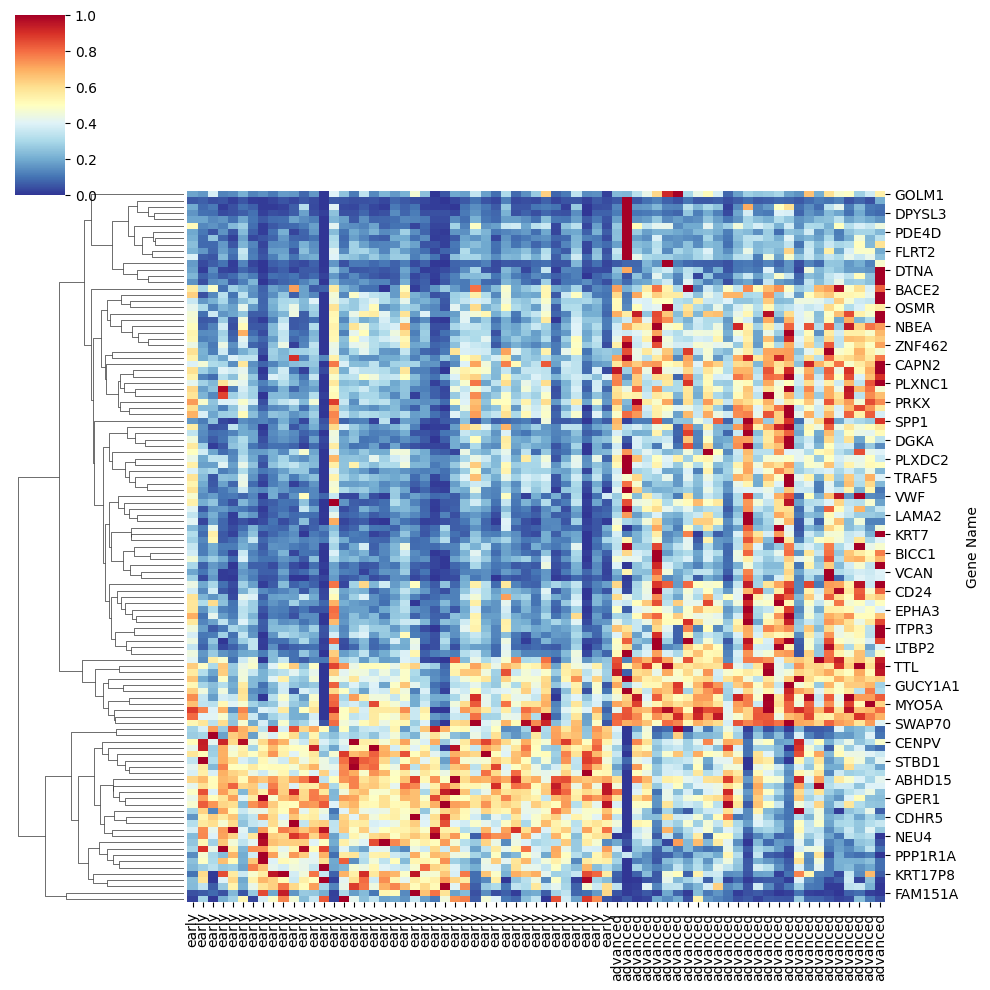

In [46]:
# Default plot
sns.clustermap(heatmap_df, standard_scale=0, cmap = 'RdYlBu_r', col_cluster=False, 
               xticklabels=metadata.sort_values("stage", ascending=False)["stage"].tolist())

# Show the graph
plt.show()

It is hard to compare the results with the paper as it is unknow how are the heatmap scaled. 

Generally speaking, there are four groups of genes differently expressed between early and advanced stage of fibrosis. Based on the heatmap from the top to bottom, 
* The top group is more or less the same in both stage, and seems to be skewed by a couple of outlier samples.
* The second group is more up-regulated in advanced stage.
* The third group is is upregulated in both, but more extreme in advanced stage.
* And the bottome one is more upregulated in early stage.


Note the counts are normalized by mean counts within each sample, and heatmap is normalized for each gene on a standard scale, meaning all raw counts are subtract by the minimum and divide each by its maximum for each gene. So it is a relative counts per gene level.

## Preparing gene list for enrichment analysis

In [29]:
# # Gene name mapping from other sources
# from sanbomics.tools import id_map
# mapper = id_map(species = 'human')

# x = df[['Gene ID', 'Gene Name']][df['Gene ID'].isin(results_df.iloc[:99].index.tolist())]
# x['Symbol'] = x['Gene ID'].map(mapper.mapper) 
# x

In [30]:
# For enrichment analysis, keep the less stringent DEGs
sig_genes1 = results_df[results_df.padj < 0.05].index.tolist()

# keep only significant genes and transpose so genes are rows
gene_df = filtered_df[sig_genes1]

gene_list = df['Gene Name'][(df['Gene ID'].isin(gene_df.columns.tolist())) & (~df['Gene Name'].isna())].tolist()

In [31]:
with open('../outputs/gene_list.pkl', 'wb') as f:
    pkl.dump(gene_list, f)